Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /root/code/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /root/code/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /root/code/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /root/code/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorfl

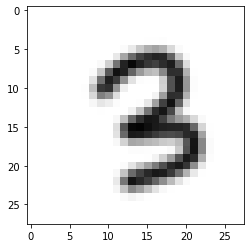

识别结果:
3


In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from datetime import datetime
from PIL import Image, ImageFilter

import matplotlib.pyplot as plt
#载入数据
mnist = input_data.read_data_sets("/root/code/MNIST_data/",one_hot=True)
lr = 1e-3
# 在训练和测试的时候，我们想用不同的 batch_size.所以采用占位符的方式
keep_prob = tf.placeholder(tf.float32, [],name='keep_prob')
batch_size = tf.placeholder(tf.int32, [],name='batch_size')
 
# 每个时刻的输入特征是28维的，就是每个时刻输入一行，一行有 28 个像素
input_size = 28
# 时序持续长度为28，即每做一次预测，需要先输入28行
timestep_size = 28
# 每个隐含层的节点数
hidden_size = 256
# LSTM layer 的层数
layer_num = 10
# 最后输出分类类别数量，如果是回归预测的话应该是 1
class_num = 10



_X = tf.placeholder(tf.float32, [None, 784],name='x')
y = tf.placeholder(tf.float32, [None, class_num],name='y')

X = tf.reshape(_X, [-1, 28, 28])

stacked_rnn = []
for iiLyr in range(layer_num):
    stacked_rnn.append(tf.nn.rnn_cell.LSTMCell(num_units=hidden_size, state_is_tuple=True))
mlstm_cell = tf.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn, state_is_tuple=True)
init_state = mlstm_cell.zero_state(batch_size, dtype=tf.float32)

outputs = list()
state = init_state
with tf.variable_scope('RNN'):
    for timestep in range(timestep_size):
        if timestep > 0:
            tf.get_variable_scope().reuse_variables()
        # 这里的state保存了每一层 LSTM 的状态
        (cell_output, state) = mlstm_cell(X[:, timestep, :], state)
        outputs.append(cell_output)
h_state = outputs[-1]

W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1,shape=[class_num]), dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(h_state, W) + bias,name="result")

# 损失和评估函数
cross_entropy = -tf.reduce_mean(y * tf.log(y_pre))
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
 
correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


saver = tf.train.Saver()
sess = tf.Session()

sess.run(tf.global_variables_initializer())
saver.restore(sess, '/tmp/tf_rnn_10/model.ckpt') #使用模型，参数和之前的代码保持一致

prediction=tf.argmax(y_pre,1)
im = Image.open('/root/code/pic_png/3.png') #读取的图片所在路径，注意是28*28像素
plt.imshow(im)  #显示需要识别的图片
plt.show()
im = im.convert('L')
tv = list(im.getdata()) 
tva = [(255-x)*1.0/255.0 for x in tv]
predint=prediction.eval(feed_dict={_X: [tva],keep_prob: 1.0,batch_size: 1}, session=sess)
#TypeError: eval() got an unexpected keyword argument 'name' 这是不是代表 sess.run的函数方式行不通了
print('识别结果:')
print(predint[0])
#用了函数处理 图像数据 所以用x:【result】

In [2]:
def predict10(sess, adds):
    import json
    num_imgs = len(adds)
    result = []
    for i in range(num_imgs):
        data = json.loads(adds[i])
        predints=sess.run('result:0',feed_dict={"x:0":data,"keep_prob:0": 1.0,'batch_size:0':1})
        result.append(str(predints[0]))
    
    return result
# predict9(sess,tva_c) 成功预测 并部署通过 数据处理可得到 预测结果

In [3]:
from clipper_admin import ClipperConnection, DockerContainerManager
from clipper_admin.deployers.tensorflow import deploy_tensorflow_model
clipper_conn = ClipperConnection(DockerContainerManager())

In [4]:
clipper_conn.start_clipper()

20-05-11:05:52:14 INFO     [docker_container_manager.py:184] [default-cluster] Starting managed Redis instance in Docker
20-05-11:05:52:19 INFO     [docker_container_manager.py:276] [default-cluster] Metric Configuration Saved at /tmp/tmpt73ijjeu.yml
20-05-11:05:52:20 INFO     [clipper_admin.py:162] [default-cluster] Clipper is running


In [5]:
clipper_conn.connect()

20-05-11:05:52:21 INFO     [clipper_admin.py:172] [default-cluster] Successfully connected to Clipper cluster at localhost:1337


In [6]:
clipper_conn.register_application(
    name="mnist_rnn-app", input_type="strings", default_output="-1.0", slo_micros=100000)

20-05-11:05:52:26 INFO     [clipper_admin.py:236] [default-cluster] Application mnist_rnn-app was successfully registered


In [7]:
deploy_tensorflow_model(
    clipper_conn,
    name="mnist-rnn-mod",
    version=1, # version 2 of the same model, `predict` endpoint will be updated 
    # automatically to the newest model version
    input_type="strings",
     func=predict10,
    tf_sess_or_saved_model_path=sess,
   )

20-05-11:05:52:27 INFO     [deployer_utils.py:41] Saving function to /tmp/tmpfp0f_a91clipper
20-05-11:05:52:27 INFO     [deployer_utils.py:51] Serialized and supplied predict function
20-05-11:05:52:31 INFO     [tensorflow.py:196] TensorFlow model saved at: /tmp/tmpfp0f_a91clipper/tfmodel/model.ckpt 
20-05-11:05:52:31 INFO     [tensorflow.py:277] Using Python 3.6 base image
20-05-11:05:52:32 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmpfp0f_a91clipper
20-05-11:05:52:34 INFO     [clipper_admin.py:539] [default-cluster] Step 1/2 : FROM clipper/tf36-container:0.4.1
20-05-11:05:52:34 INFO     [clipper_admin.py:539] [default-cluster]  ---> 3db42af800ff
20-05-11:05:52:34 INFO     [clipper_admin.py:539] [default-cluster] Step 2/2 : COPY /tmp/tmpfp0f_a91clipper /model/
20-05-11:05:52:34 INFO     [clipper_admin.py:539] [default-cluster]  ---> 05bd89eefd95
20-05-11:05:52:34 INFO     [clipper_admin.py:539] [default-cluster] Successfull

In [8]:
sess

In [9]:
# Link the model and the app
clipper_conn.link_model_to_app(
    app_name="mnist_rnn-app",
    model_name="mnist-rnn-mod")

20-05-11:05:52:47 INFO     [clipper_admin.py:303] [default-cluster] Model mnist-rnn-mod is now linked to application mnist_rnn-app


In [10]:
# Get query address
query_address = clipper_conn.get_query_addr()
print(query_address)

localhost:1337


In [13]:
import matplotlib.pyplot as plt
import base64
import json
import requests
from datetime import datetime



def query_json(addr, filename,mnist,sess):
    url = "http://%s/mnist_rnn-app/predict" % addr

    im = Image.open(filename)
    plt.imshow(im)  #显示需要识别的图片
    plt.show()
    im = im.convert('L')
    tv = list(im.getdata())
    tva = [[(255-x)*1.0/255.0 for x in tv]]
    tva = json.dumps(tva)
    tva_j = json.dumps({"input": tva})
    headers = {'Content-type': 'application/json'}
    start = datetime.now()
    r = requests.post(url, headers=headers, data=tva_j)
    end = datetime.now()
    latency = (end - start).total_seconds() * 1000.0
    re = r.text
    global false, null, true

    false = null = true = ''
    ls = eval(re)
    numbers = ls['output']
    numbers_str = numbers[1:-1]
    numbers_str=numbers_str.replace("\n", "")
    list1 = numbers_str.split(' ')
    print("this number is "+ str(list1.index(max(list1)))+" , "+"The latency is   "+str(latency))
    train_accuracy = sess.run(accuracy, feed_dict={
            _X:mnist.test.images, y: mnist.test.labels, keep_prob: 1.0, batch_size: 10000})
    print(" test accuracy %g" % ( train_accuracy))
    return (list1.index(max(list1)))

Extracting /root/code/MNIST_data/train-images-idx3-ubyte.gz
Extracting /root/code/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /root/code/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /root/code/MNIST_data/t10k-labels-idx1-ubyte.gz


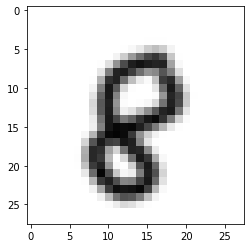

this number is 8 , The latency is   6.87
 test accuracy 0.9841


8

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/root/code/MNIST_data/', one_hot=True) 
query_json(query_address, "/root/code/pic_png/8.png",mnist,sess)

In [15]:
clipper_conn.stop_all()

20-05-11:05:54:36 INFO     [clipper_admin.py:1424] [default-cluster] Stopped all Clipper cluster and all model containers
